<a href="https://colab.research.google.com/github/srinivasanibmbangalore/OpenCVDeepLearningCertification/blob/master/HoughTransforms_Lane_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [74]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/ml_data/OpenCVCertification/images'
imgPath=root_path+"/road_lanes.jpg"
tbPath=root_path+"/tubes.jpg"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**### Naive Way of Detecting Lanes.**

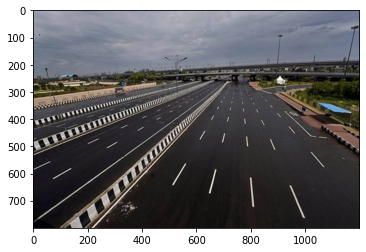

In [13]:
img = cv2.imread(imgPath,1)
if (img.any() == None):
  print("Empty Image")

plt.imshow(img[...,::-1])

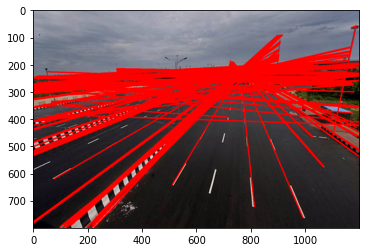

In [14]:

# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Find the edges in the image using canny detector
edges = cv2.Canny(gray, 50, 200)
# Detect points that form a line
# in row direction, resolution is one pixel
#and in theta direction, resolution is one degree. Atleast 100 edges vote for a line.
# if a line has less than 10 pixels, ignore
# lines can be broken. If more than 250 pixels broken, dont consider it.
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=10, maxLineGap=200) 

# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 3)
# Show result
plt.imshow(img[:,:,::-1])

Hough Circles

## Clean Way - 

In [20]:
def do_canny(img):
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Applies a 5x5 gaussian blur with deviation of 0 to frame - not mandatory since Canny will do this for us
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Applies Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv2.Canny(blur, 50, 150)
    return canny

Segmenting lane area
We will handcraft a triangular mask to segment the lane area and discard the irrelevant areas in the frame to increase the effectiveness of our later stages.

In [58]:
def do_segment(frame):
    # Since an image is a multi-directional array containing the relative intensities of each pixel in the image, we can use frame.shape to return a tuple: [number of rows, number of columns, number of channels] of the dimensions of the frame
    # frame.shape[0] give us the number of rows of pixels the frame has. Since height begins from 0 at the top, the y-coordinate of the bottom of the frame is its height
    height = frame.shape[0]
    # Creates a triangular polygon for the mask defined by three (x, y) coordinates
    polygons = np.array([
                            [(0, height), (800, 300), (100,100)]
                        ])
    # Creates an image filled with zero intensities with the same dimensions as the frame
    mask = np.zeros_like(frame)
    # Allows the mask to be filled with values of 1 and the other areas to be filled with values of 0
    cv2.fillPoly(mask, polygons, 255)
    # A bitwise and operation between the mask and frame keeps only the triangular area of the frame
    segment = cv2.bitwise_and(frame, mask)
    return segment

In [65]:
def calculate_lines(frame, lines):
    # Empty arrays to store the coordinates of the left and right lines
    left = []
    right = []
    # Loops through every detected line
    for line in lines:
        # Reshapes line from 2D array to 1D array
        x1, y1, x2, y2 = line.reshape(4)
        # Fits a linear polynomial to the x and y coordinates and returns a vector of coefficients which describe the slope and y-intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_intercept = parameters[1]
        # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
    # Averages out all the values for left and right into a single slope and y-intercept value for each line
    left_avg = np.average(left, axis = 0)
    right_avg = np.average(right, axis = 0)
    # Calculates the x1, y1, x2, y2 coordinates for the left and right lines
    left_line = calculate_coordinates(frame, left_avg)
    right_line = calculate_coordinates(frame, right_avg)
    return np.array([left_line, right_line])

In [66]:
def calculate_coordinates(frame, parameters):
    slope, intercept = parameters
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    y1 = frame.shape[0]
    # Sets final y-coordinate as 150 above the bottom of the frame
    y2 = int(y1 - 150)
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = int((y1 - intercept) / slope)
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


In [70]:
def visualize_lines(frame, lines):
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    # Checks if any lines are detected
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            # Draws lines between two coordinates with green color and 5 thickness
            cv2.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return lines_visualize

In [ ]:
img = cv2.imread(imgPath,1)
if (img.any() == None):
  print("Empty Image")

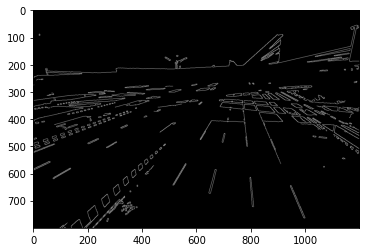

In [22]:
canny = do_canny(img)
plt.imshow(canny,cmap='gray')

In [59]:
segment = do_segment(canny)

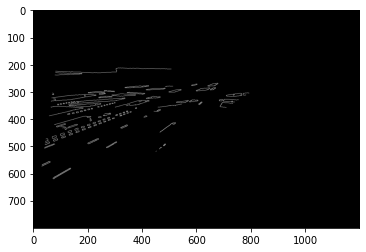

In [60]:
plt.imshow(segment,cmap='gray')

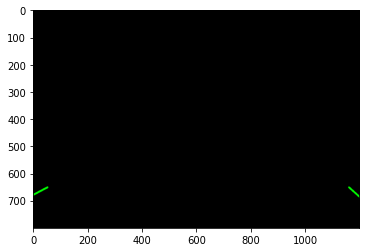

In [73]:
hough = cv2.HoughLinesP(canny, 1, np.pi/180, 100, minLineLength=50, maxLineGap=200) 
lines = calculate_lines(img, hough)
lines_visualize = visualize_lines(img, lines)
plt.imshow(lines_visualize)


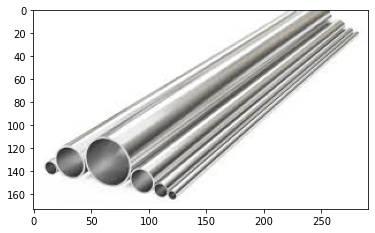

In [77]:
tbImg = cv2.imread(tbPath,1)
if (tbImg.any() == None):
  print("Empty Image")

plt.imshow(tbImg[...,::-1])

circles - Output vector of found circles. Each vector is encoded as 3 or 4 element floating-point vector (x,y,radius) or (x,y,radius,votes) .
method - Detection method. Currently, the only implemented method is HOUGH_GRADIENT
dp - Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height.
minDist - Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.
param1 - First method-specific parameter. In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller).
param2 - Second method-specific parameter. In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first.
minRadius - Minimum circle radius.
maxRadius - Maximum circle radius. If <= 0, uses the maximum image dimension. If < 0, returns centers without finding the radius.

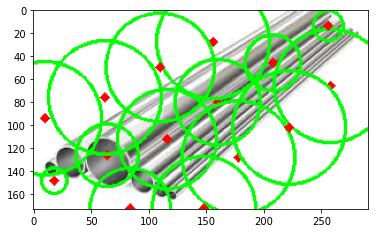

In [100]:
tbImg = cv2.imread(tbPath,1)
if (tbImg.any() == None):
  print("Empty Image")
gray = cv2.cvtColor(tbImg, cv2.COLOR_BGR2GRAY)
# Blur the image to reduce noise
img_blur = cv2.medianBlur(gray, 5)
# Apply hough transform on the image
circles = cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1, 50, param1=5, param2=10, minRadius=5, maxRadius=50)
# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        # Draw outer circle
        cv2.circle(tbImg, (i[0], i[1]), i[2], (0, 255, 0), 2)
        # Draw inner circle
        cv2.circle(tbImg, (i[0], i[1]), 2, (0, 0, 255), 3)
plt.imshow(tbImg[:,:,::-1])